### Задание №1.
   - Сформировать с помощью `sklearn.make_classification` датасет из 1000 объектов с **двумя** признаками.  
   - Обучить случайный лес из 1, 3, 10, 50, 100 и 200 деревьев (за основу взять реализацию построения этого алгоритма из урока).  
   - Визуализировать их разделяющие линии на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции `predict` на `tree_vote`).   
   - Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [1]:
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

In [3]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.classes = self.get_classes()
        self.prediction = self.predict()
    
    def get_classes(self):
        classes = {}
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        return classes
        
    def predict(self):    
        prediction = max(self.classes, key=self.classes.get)
        return prediction

In [4]:
def get_inform_index(labels, type_index='gini'):
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    if type == 'gini':
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2
    else:
        impurity = 0
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p * np.log2(p) 
        
    return impurity

In [5]:
def quality(left_labels, right_labels, type_index, current_index):

    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_index - p * get_inform_index(left_labels, type_index) - (1 - p) * get_inform_index(right_labels, type_index)

In [6]:
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [7]:
def find_best_split(data, labels, min_leaf, inform_index):
    current_index = get_inform_index(labels, inform_index)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # Генерируем массив индексов подмножества признаков
    subsample = np.random.permutation(n_features)[:int(np.sqrt(n_features))]
    
    for index in subsample:
        
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, inform_index, current_index)
            
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [8]:
def build_tree(data, labels, min_leaf=1, max_depth=None, inform_index='gini'):

    quality, t, index = find_best_split(data, labels, min_leaf, inform_index)

    if quality == 0 or max_depth == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    if max_depth:
        true_branch = build_tree(true_data, true_labels, min_leaf, max_depth - 1)
        false_branch = build_tree(false_data, false_labels, min_leaf, max_depth - 1)
    else:
        true_branch = build_tree(true_data, true_labels, min_leaf)
        false_branch = build_tree(false_data, false_labels, min_leaf)
        
    return Node(index, t, true_branch, false_branch)

In [9]:
def random_forest(data, labels, n_trees):
    forest = []
    
    for i in range(n_trees):
        # Для каждого дерева генерируем рандомно массивы индексов для бустрап-подвыборок, для каждой строим дерево
        b_index = np.random.randint(0, data.shape[0], data.shape[0])
        forest.append(build_tree(data[b_index], labels[b_index]))
        
    return forest

In [10]:
def classify_object(obj, node):

    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [11]:
def predict(data, tree):
    
    preds = []
    for obj in data:
        prediction = classify_object(obj, tree)
        preds.append(prediction)
    return np.array(preds)

In [12]:
def tree_vote(data, forest):

    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    predictions = np.array(predictions)
    
    voted_predictions = predictions.mean(axis=0)
        
    return np.where(voted_predictions >= 0.5, 1, 0)

In [13]:
def accuracy_metric(real, pred):
    return np.sum(real == pred) * 100 / real.shape[0]

In [14]:
class_data, class_labels = make_classification(n_samples=1000,
                                               n_features=2, n_informative=2, 
                                               n_classes=2, n_redundant=0, 
                                               n_clusters_per_class=2, flip_y=0.1, random_state=1)

In [15]:
train_data, test_data, train_labels, test_labels = train_test_split(class_data, 
                                                                    class_labels, 
                                                                    test_size = 0.3,
                                                                    random_state = 1)

__1 дерево:__

In [16]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [17]:
train_answers_1 = tree_vote(train_data, my_forest_1)

In [18]:
test_answers_1 = tree_vote(test_data, my_forest_1)

In [19]:
train_accuracy_1 = accuracy_metric(train_labels, train_answers_1)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_1:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 90.857


In [20]:
test_accuracy_1 = accuracy_metric(test_labels, test_answers_1)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_1:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 70.000


__3 дерева:__

In [21]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

In [22]:
train_answers_3 = tree_vote(train_data, my_forest_3)

In [23]:
test_answers_3 = tree_vote(test_data, my_forest_3)

In [24]:
train_accuracy_3 = accuracy_metric(train_labels, train_answers_3)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_3:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 96.000


In [25]:
test_accuracy_3 = accuracy_metric(test_labels, test_answers_3)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_3:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 76.333


__10 деревьев:__

In [26]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

In [27]:
train_answers_10 = tree_vote(train_data, my_forest_10)

In [28]:
test_answers_10 = tree_vote(test_data, my_forest_10)

In [29]:
train_accuracy_10 = accuracy_metric(train_labels, train_answers_10)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_10:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 98.000


In [30]:
test_accuracy_10 = accuracy_metric(test_labels, test_answers_10)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_10:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 79.667


__50 деревьев:__

In [31]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

In [32]:
train_answers_50 = tree_vote(train_data, my_forest_50)

In [33]:
test_answers_50 = tree_vote(test_data, my_forest_50)

In [34]:
train_accuracy_50 = accuracy_metric(train_labels, train_answers_50)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_50:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000


In [35]:
test_accuracy_50 = accuracy_metric(test_labels, test_answers_50)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_50:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 79.333


__100 деревьев:__

In [36]:
n_trees = 100
my_forest_100 = random_forest(train_data, train_labels, n_trees)

In [37]:
train_answers_100 = tree_vote(train_data, my_forest_100)

In [38]:
test_answers_100 = tree_vote(test_data, my_forest_100)

In [39]:
train_accuracy_100 = accuracy_metric(train_labels, train_answers_100)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_100:.3f}')

Точность случайного леса из 100 деревьев на обучающей выборке: 100.000


In [40]:
test_accuracy_100 = accuracy_metric(test_labels, test_answers_100)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_100:.3f}')

Точность случайного леса из 100 деревьев на тестовой выборке: 79.333


__200 деревьев:__

In [41]:
n_trees = 200
my_forest_200 = random_forest(train_data, train_labels, n_trees)

In [42]:
train_answers_200 = tree_vote(train_data, my_forest_200)

In [43]:
test_answers_200 = tree_vote(test_data, my_forest_200)

In [44]:
train_accuracy_200 = accuracy_metric(train_labels, train_answers_200)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_200:.3f}')

Точность случайного леса из 200 деревьев на обучающей выборке: 100.000


In [45]:
test_accuracy_200 = accuracy_metric(test_labels, test_answers_200)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy_200:.3f}')

Точность случайного леса из 200 деревьев на тестовой выборке: 79.000


Как видим из подсчета accuracy модель начала переобучаться при переходе от 50 к 100 деревьям.

Построим графики:

Text(0.5, 1.0, '200 trees. Test accuracy=79.00')

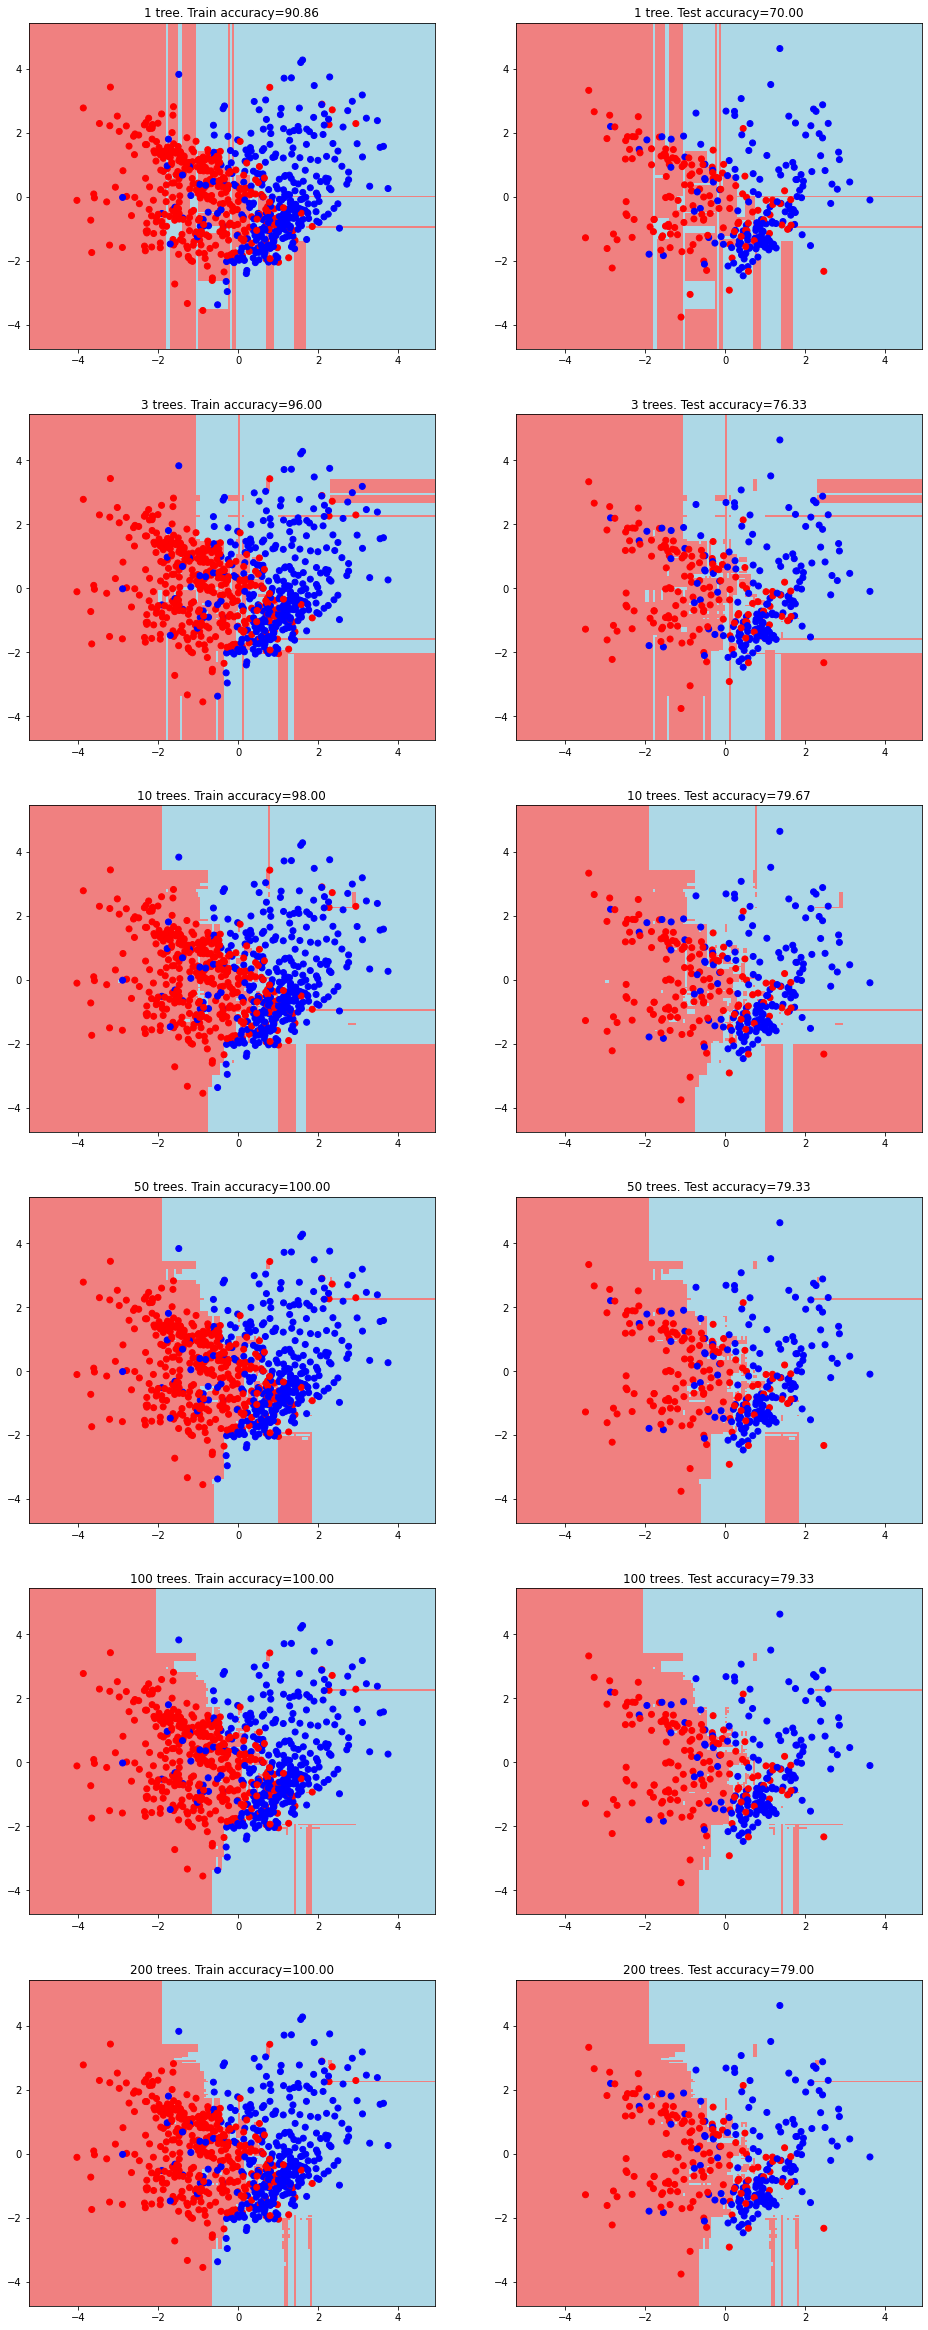

In [46]:
import warnings

def get_meshgrid(data, step=0.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

warnings.filterwarnings('ignore')

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize = (16, 42))

# 1 дерево
# график обучающей выборки
plt.subplot(6,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(np.c_[xx.ravel(), yy.ravel()], my_forest_1)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'1 tree. Train accuracy={train_accuracy_1:.2f}')
# график тестовой выборки
plt.subplot(6,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'1 tree. Test accuracy={test_accuracy_1:.2f}')

# 3 дерева
# график обучающей выборки
plt.subplot(6,2,3)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(np.c_[xx.ravel(), yy.ravel()], my_forest_3)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'3 trees. Train accuracy={train_accuracy_3:.2f}')
# график тестовой выборки
plt.subplot(6,2,4)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'3 trees. Test accuracy={test_accuracy_3:.2f}')

# 10 деревьев
# график обучающей выборки
plt.subplot(6,2,5)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(np.c_[xx.ravel(), yy.ravel()], my_forest_10)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'10 trees. Train accuracy={train_accuracy_10:.2f}')
# график тестовой выборки
plt.subplot(6,2,6)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'10 trees. Test accuracy={test_accuracy_10:.2f}')

# 50 деревьев
# график обучающей выборки
plt.subplot(6,2,7)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(np.c_[xx.ravel(), yy.ravel()], my_forest_50)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'50 trees. Train accuracy={train_accuracy_50:.2f}')
# график тестовой выборки
plt.subplot(6,2,8)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'50 trees. Test accuracy={test_accuracy_50:.2f}')

# 100 деревьев
# график обучающей выборки
plt.subplot(6,2,9)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(np.c_[xx.ravel(), yy.ravel()], my_forest_100)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'100 trees. Train accuracy={train_accuracy_100:.2f}')
# график тестовой выборки
plt.subplot(6,2,10)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'100 trees. Test accuracy={test_accuracy_100:.2f}')

# 200 деревьев
# график обучающей выборки
plt.subplot(6,2,11)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(np.c_[xx.ravel(), yy.ravel()], my_forest_200)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'200 trees. Train accuracy={train_accuracy_200:.2f}')
# график тестовой выборки
plt.subplot(6,2,12)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'200 trees. Test accuracy={test_accuracy_200:.2f}')